<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/pytorch/notebooks/python/Lab_LLM_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large Language Models

In this lab we will use LLM programmatically to understand their capabilities, to extend what we can done locally. Currently, this lab is focused on the use of OpenAI's API. There are other competitors, such as [Mistral](https://docs.mistral.ai/api/), but so far, GPT-4 and its derivatives are the dominating models in pretty much [all benchmarks](https://www.reddit.com/r/ChatGPT/comments/16f6i1x/llm_benchmarks_a_curated_structured_list/).

Another factor to consider are the licenses of the models, and whether they allow commercial use or not. A potential list is [here](https://github.com/eugeneyan/open-llms) and the license explanation [here](https://medium.com/@mne/understanding-permissive-licenses-for-large-language-models-llms-843d40909ce0).

To use this lab, we will need an OpenAI key. I will provide one during the lecture which I will then delete. If you want to replicate this lab for personal use, you must follow the instructions in [this page](https://platform.openai.com/docs/quickstart?context=python) to get your key. Let's start by setting up the packages and setting up the key.

In [ ]:
# Install OpenAI package
!pip install cohere tiktoken
!pip install --upgrade openai

In [ ]:
from openai import OpenAI
import os
import sys

# Imports
import numpy as np
import os
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import graphviz
from matplotlib.colors import ListedColormap
graphviz.set_jupyter_format('png')
%matplotlib inline


In [ ]:
# Load the API Key
!gdown https://drive.google.com/uc?id=1jOKiUC9f55GqUHOOiNCTWZN5ETba3b9N
file = 'TeachingKeyOAI.txt'

with open(os.path.normpath(file), "r") as f:
    api_key = f.readline().strip()
    os.environ['OPENAI_API_KEY'] = api_key

!rm TeachingKeyOAI.txt

In [ ]:
client = OpenAI()

## Our first API request.

The OpenAI API is [vast](https://platform.openai.com/docs/api-reference/chat?lang=python). In this tutorial we will focus on handling text data and will test the image generation system for good measure. In line with other APIs, every request that we do has a small cost, which can be seen [here](https://openai.com/pricing) for OpenAI.

We will use ```gpt-3.5-turbo-0125``` for our experiments. OpenAI's flagship model of the 3 family of models, with a context of 16,000 tokens. The model has been optimized for dialog, so it is a great starting point at a very low cost.

**Tip: If you are developing an App, start by using this model until you are satisfied with the result. Then scale up to a more complex version if necessary.**

Let's ask for a summary of Banking Analytics.


In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a research assistant in the field of analytics."},
    {"role": "user", "content": "Explain the research field of Banking Analytics and its differences with the more general Business Analytics"}
  ]
)

print(completion.choices[0].message.content)

In [ ]:
print(completion.choices[0].message.content)

Of note here is that, when we are using the API, we are exposed to more fields than the chat itself. A general API call to the Chat Completitions API can be seen [here](https://platform.openai.com/docs/api-reference/chat/create), but the most important parameters are:

1. The ```model```. There are many models to choose from, each with different prices and performances. Use the most cost-effective one for your application!
2. The ```messages``` dictionary. Here we have the two most important parts of the message. The "system" role, which tells the general context to the LLM that we want it to focus on, and the "user" role, which is the text of the query itself.
3. The ```max_tokens```: How many tokens to return. Quantifying the number of tokens in a request is a bit tricky, the API provides a function to know exactly the cost of your requests.
4. The ```temperature```: LLM are non-deterministic in their responses. The level of creativity that the system implements will depend on the temperature that you give it. For creative work, you want the number to be 1 or slightly above. For more technical work, 0.8-0.9 is a good number. Experiment with a few!
5. The ```seed```: Very recently OpenAI allowed for fully deterministic responses by allowing the user to set a seed value.
6. The ```presence_penalty```: A number between -2 and 2 that sets a penalty for repeating words.

Let's use these parameters to change a bit the tone of our LLM.


In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a research assistant in the field of analytics."},
    {"role": "user", "content": "Explain the research field of Banking Analytics and its difference with the more general Business Analytics"},
  ],
  temperature=0.8,
  max_tokens=512,
  presence_penalty=-1.0,
)

print(completion.choices[0].message.content)

What changed? Now we know how to programmatically query ChatGPT!

Let's use it for image generation. The model that does this is called Dall-E, in it's third version by now. I would expect very soon we'll get a fully multimodal model that will include both text and image generation, I'd be surprised if it does not come during 2024.

In [ ]:
image = client.images.generate(
    model="dall-e-2",
    prompt="A logo that summarizes the field of banking analytics, showcasing mortgages, and how they relate to banks and people in a large financial network.",
    n=1,
    size="256x256",
    # quality="hd",
    style="natural", # Or vivid
    )

The API will automatically preprocess our request in a revised prompt.

In [ ]:
print(image.data[0].revised_prompt)

And returns a URL with our created image.

In [ ]:
print(image.data[0].url)

This is the image that Dall-E-3 creates, costing $0.16.

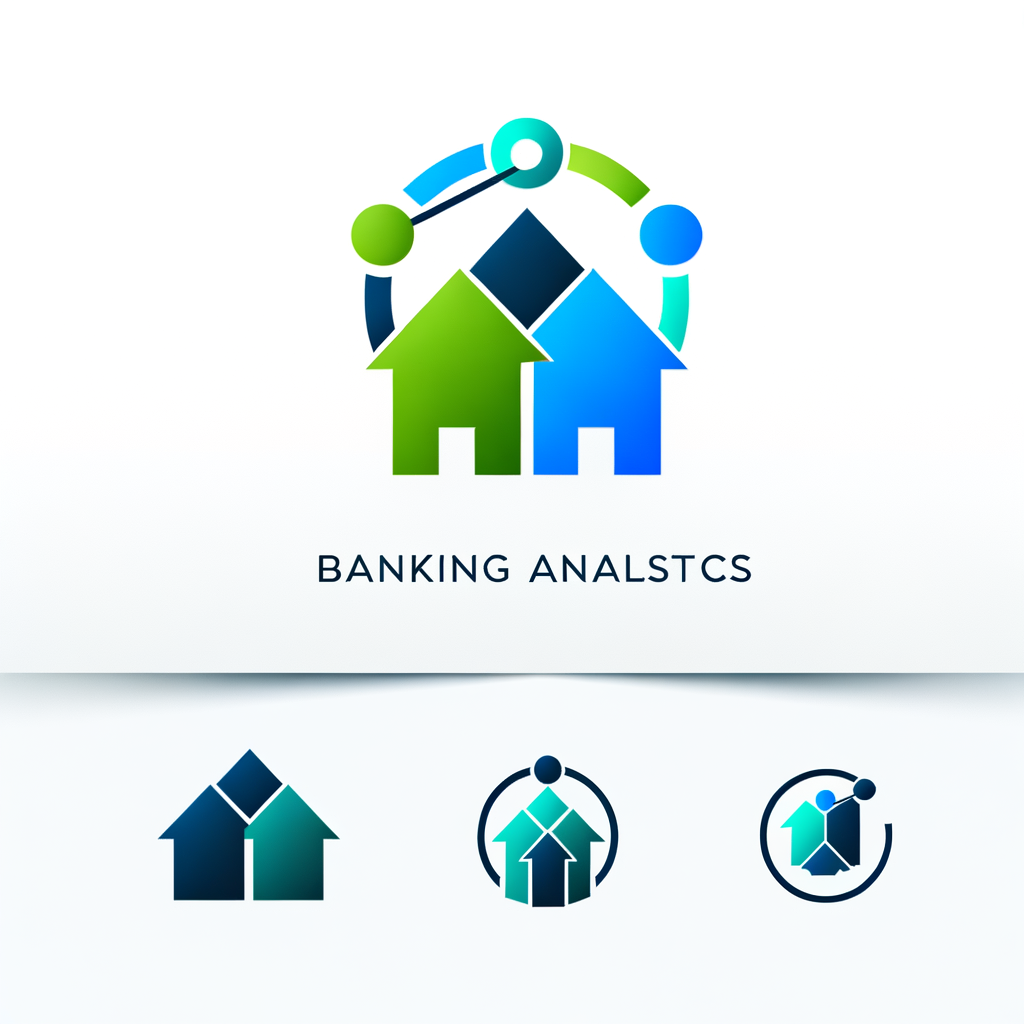

Very simple and direct. Play with the prompts to make it work better for you!

## Embeddings

Another application we can use is the creation of vector datasets, which can be used to create text models of our data. Let's import the financial statement dataset from our Transformer lab.

In [ ]:
# Get the data and unzip it.
!gdown 'https://drive.google.com/uc?id=10ZeK1qEyj6Rg-IMghH_J7RBfFobb4-ZB'

# Extract the files.
!unzip InvestorCallDataProcessed.zip

# Read data.
investor_df = pd.read_csv('InvestorCallDataProcessed.csv')

# Drop unused column
investor_df.drop(columns='RATING_TYPE', inplace=True)

# Set to categories
investor_df['RATING'] = investor_df['RATING'].astype('category')

# Set a vector with the ratings
ratings = ['RatingA', 'RatingA-', 'RatingAAA-A+', 'RatingBBB', 'RatingBBB+', 'RatingBBBM-BB', 'RatingBBM-B', 'RatingBM-C']

# Show result
investor_df.head()

Let's also load the last investor call by Eli Lilly, to see where it falls according to OpenAI.

In [ ]:
text = "Eli Lilly and Co (NYSE:LLY) All right, thanks, Joe. 2023 was a year of advancement across our company. We grew our top-line. We progressed our pipeline. It advanced our external innovation agenda through partnerships and collaborations. We continue to invest in quality, the reliability and the resilience of our company's manufacturing infrastructure, and most importantly, delivered new life-saving and life-changing medicines to more patients.  In 2023, revenue grew 20% for the full year and 28% for the most recent quarter, as our newly launched portfolio continued to gain momentum. This past year, we announced positive Phase IIIs for Donanemab, Tirzepatide, Mirikizumab And Pertibrutinib. We also announced a positive Phase II result for Orforglipron as well as Retatrutide and moved these two important molecules into Phase III.  In terms of external innovation, in 2023, we continued to complement our pipeline through acquisitions and collaborations. These transactions included the acquisition of DICE Therapeutics, POINT Biopharma, Versanis Bio, Emergence Therapeutics, Mablink Biosciences, Immunotrac as well as Sigilon Therapeutics. We have several significant investments in manufacturing, including plans to expand capacity at the company's Research Triangle Park facility and the two manufacturing sites within the LEAP Innovation Park in Boone County, Indiana.  Most recently, we announced plans to construct a new high-tech manufacturing site in Germany. This facility will further expand the company's global injectable product and device manufacturing network, including for our diabetes and obesity portfolio. Most importantly, this past year, we brought innovative new medicines to patients.  In 2023, we received regulatory approvals for Zepbound, Jaypirca, Omvoh, in the U.S. -- in the EU rather, and an expanded label for Verzenio and two new indications for Jardiance. This progress will serve as a foundation to drive top-tier revenue growth and margin expansion over time.  As you can see on Slide 4, we continue to make progress against our strategic deliverables in Q4. Revenue grew 28% with our new products growing by over $2 billion. Since our last earnings call, we achieved several key pipeline milestones in addition to the Zepbound and Jaypirca CLL approvals, today, we announced top line results for the Tirzepatide Phase II SYNERGY-NASH trial as well as the Verzenio Phase III CYCLONE two trial. Dan will talk more about this update -- in his update.  In terms of business development, in Q4, we completed the acquisitions of Mablink Bioscience and POINT Biopharma, the latter of which expands our capacity and capability into Radioligand therapies. Lastly, we announced a 15% dividend increase for the sixth consecutive year and distributed over $1 billion in dividends in the fourth quarter. Thanks, Dave. Slide six summarizes financial performance in the fourth quarter of 2023, and I'll focus my comments on non-GAAP performance. We are pleased with the strong financial performance in the fourth quarter and for the full year. Our performance was highlighted by continued acceleration of revenue growth, driven by our new products and growth products.  Q4 revenue increased 28% compared to Q4 2022. Excluding divestiture, this represents a quarter-over-quarter acceleration revenue growth driven by Mounjaro, Verzenio, Jardiance and the recent launch of Zepbound. For the full year, revenue increased 20% driven by robust volume growth of 16%. Gross margin as a percent of revenue increased to 82.3%. Gross margin in the quarter benefited from higher realized prices, partially offset by higher manufacturing expenses.  Marketing, selling and administrative expenses increased 17%, primarily driven by higher expenses associated with launches of new products and additional indications as well as higher incentive compensation costs. R&D expenses increased 28%, primarily driven by higher development expenses for late-stage assets and additional investments in early-stage research as well as higher incentive compensation costs.  In Q4, we recognized acquired IPR&D charges of $623 million, which negatively impacted EPS by $0.62. In Q4 2022, acquired IPR&D charges totaled $240 million or $0.23 negative impact to EPS. Operating income increased 29% in Q4, driven by higher revenue from new launches, partially offset by operating expense growth.  Operating income as a percent of revenue was approximately 28% for the quarter and included a negative impact of approximately seven percentage points attributable to acquired IPR&D charges. Our Q4 effective tax rate was 13.1% compared to 7.3% in Q4 2022.  The higher effective tax rate for Q4 2023 was primarily driven by a lower net discrete tax benefit compared to the same period in 2022 and the new Puerto Rico tax regime. At the bottom line, we delivered earnings per share of $2.49 in Q4, a 19% increase compared to Q4 2022, inclusive of the negative impact of $0.62 from acquired IPR&D charges compared to $0.23 in Q4 2022.  On Slide 8, we quantify the effect of price, rate and volume on revenue growth. U.S. revenue increased 39% in Q4, driven by robust growth of Mounjaro, Verzenio and Zepbound. Net price in the U.S. increased 27% for the quarter, driven by Mounjaro access and savings cards dynamic as well as the onetime favorable change in estimates for rebates and discounts. Excluding Mounjaro, net price in the U.S. decreased by high single digits.  Europe continued its trend of strong growth in Q4. Excluding $65 million in revenue associated with milestones received for the EU approval and launch of Revenue was up 11% in constant currency, driven primarily by volume growth of Verzenio, Jardiance and Taltz. For Japan, we are pleased to see robust growth in Q4 as revenue increased 15% in constant currency, driven primarily by volume growth of Verzenio and Mounjaro.  Moving to China, Q4 revenue increased 7% in constant currency with volume growth of 10% partially offset by price declines. Volume growth in Q4 was primarily driven by Pivot. We are pleased to see China return to growth in 2023. Revenue in the rest of the world decreased 10% in constant currency. However, when you exclude the impact of the Q4 2022 sales of rights for Alimta Korea and Taiwan, sales grew 9% in constant currency, driven primarily by volume growth of Mounjaro and Verzenio.  Slide nine shows the contribution to worldwide volume growth by product category. As you can see, the new products and growth product categories combined contributed approximately 15 percentage points of volume growth for the quarter. Slide 10 provides additional perspective across our product categories.  First, I would like to highlight Verzenio, which saw worldwide sales growth of 42% in Q4 driven by robust demand growth and, to a lesser extent, higher realized prices. The continued positive momentum is driven by early breast cancer indication with steady performance in the metastatic indication. Jardiance continued its strong 2023 performance with worldwide revenue growth of 30% for the quarter. In the U.S., Jardiance revenue increased 29%, driven by increased demand.  In Q4, worldwide Trulicity revenue declined 14%. U.S. revenue decreased 18% driven by lower volume and lower realized prices. We experienced intermittent delays for filling orders of Trulicity. Starting in early December and going through January, all dose strengths of Trulicity were indicated as having limited availability on the FDA drug shortage site.  We expect to experience intermittent delays orders of certain doses in the coming months. In international markets, Trulicity volume continued to be affected by measures we have taken to minimize potential disruption to existing patients, including communications to health care professionals not to start new patients on Trulicity.  Moving to Slide 11, Mounjaro continued its robust growth as more Type 2 diabetes patients benefited from the medicine. Q4 revenue grew to over $2.2 billion globally, up from $1.4 billion in Q3 2023. In the U.S., Mounjaro revenue of $2.1 billion in Q4, up from $1.3 billion in Q3 2023, benefited from a onetime change in SMS for rebates and discounts. Adjusted for this onetime change, sequential net sales in the U.S. would have grown approximately 30% in Q4.  Since our last call, we further expanded patient access to Mounjaro. As of February 1, access for patients with Type 2 diabetes in the U.S. was 90% in aggregate across commercial and Part D, including 92% access for commercial patients. This expanded access puts Mounjaro near parity with established injectable Incretins and gives more patients the opportunity to start therapy on Mounjaro for Type 2 diabetes.  Since the $25 noncovered co-pay part program expired on June 30, we now consider all prescriptions paid. Compared to Q4 2022, the Mounjaro net price in Q4 2023 benefited from this change to the co-pay part program in the U.S. Recall that after a change to the noncovered co-pay program in late 2022, patients already started on the $25 co-pay card could remain in the program until June 30. Today, commercially insured patients without coverage utilize the current noncovered co-pay program and pay roughly half the list price for Mounjaro prescription.  Turning to Slide 12. In November, we received FDA approval for Zepbound for adults with obesity or those who are overweight and have weight-related comorbidities. We then announced on December five that Zepbound available at U.S. pharmacies, and we started building commercial formulary access before the end of the year. We are pleased with the early access of approximately one-third of commercial lives covered as of February 1.  Access in this market will be more gradual as individual employers need to opt in to coverage after the typical formulary contracting takes place. We are focused on building formulary access and employer opt-ins, but we expect that it will take some time before we reach broad open access in this market.  Meanwhile, the commercial savings for our program is available at U.S. pharmacies for those who do not yet have coverage. In Medicare Part D, weight loss drugs are still prohibited from reimbursement. In Q4, we recognized $176 million in sales for Zepbound with approximately 3/4 of that coming from initial channel stocking. The initial prescription trends we have seen are encouraging.  On Slide 13, we provide an update on capital allocation. Looking forward to 2024 and beyond, we have confidence in our existing commercial portfolio, bolstered by the recent launches of Mounjaro, Jaypirca, Omvoh, and Zepbound and the potential launches of the Donanemab and Lebrikizumab, all of which we expect to serve as drivers for contained growth through the balance of the decade.  On Slide 14, you'll see a summary of our outlook; outline our capital deployment decisions in relation to achievement of our strategic deliverables. We will invest in our current portfolio and in the future innovation through R&D, business development and a comprehensive manufacturing expansion agenda designed to drive revenue growth and speed life-changing medicines to patients. We will continue to return capital to our shareholders through dividend increases in line with earnings growth over time and share repurchases with excess capital.  Moving to Slide 15, we highlight some of the dynamics that may impact our 2024 financial results. We expect continued robust revenue growth with revenue from our core business which excludes revenue from divestiture growing nearly 30% at the midpoint of our guidance range, driven by positive momentum to simply launch products. In Incretins, anticipated growth will be led by Mounjaro and Zepbound.  In 2023, we made tremendous strides in expanding access from Mounjaro, and we entered 2024 with 90% of commercial and Part D lives covered. Zepbound coverage is off to a good start in its early December launch, and we expect both Tirzepatide to contribute substantially to Lilly's revenue growth in 2024.  While we expect Mounjaro and Zepbound to be drivers of revenue growth, this will be partially offset by an expected continuation of the softer Trulicity sales trends that we saw in the second half of 2023. Recent revenue declines for Trulicity in the U.S. has been driven by supply tightness. Volume has also been impacted by our actions outside the U.S.  As for supply outlook for Emberton, our manufacturer organization continues to execute well on the most ambitious expansion agenda in our company's long history. Given strong demand and time required to bring capacity fully online, we continue to expect demand to outpace supply in 2024. In late 2022, we showed our expectation that by year-end 2023, our capacity for Incretin auto-injector pens would double. This goal was achieved through significant efforts from our manufacturing colleagues and partners around the globe.  In 2024, our capacity execution efforts will continue with equal urgency and will be accomplished not just through increased auto-injector capacity but also through alternative presentation like our multi-use Quick Pen, which received regulatory approval in the U.K. in late January. We expect our manufacturing site in Concord, North Carolina, will initiate production as early as the end of 2024, with product available to ship in 2025. And we are pursuing a host of the projects, internal and external, large and small, to further expand capacity.  Now I'll provide a bit more context on the timing and pace of our Incretin supply plans in 2024. While we're continuing to expand supply every quarter, we expect the most significant production increases to come in the second half of the year. We expect our production of sellable doses in the second half of 2024 will be at least one and a half times the production in the second half of 2023.  Note that while last year, our commentary focused on capacity of auto-injectors devices compared to 2022, we're now referring sellable doses produced, which is more relevant to patients and investors. Beyond Incretin, we look forward to progressing our launch project for two other medicine approved and launched in 2023, Jaypirca and Omvoh.  Jaypirca was initially approved by the FDA in January 2023 for adult patients with relapsed or refractory lymphoma under the accelerated approval program, received FDA approval also on the Accelerated Approval Program in December 2023 for adult patients with CLL or SLL that have received at least two prior lines of therapy. We look forward to the ongoing opportunity to help patients with this medicine as our best Phase III program continues.  Omvoh was approved in October 2023 in the U.S. and earlier that year in Japan, Europe and other markets and represents a compelling new options for patients struggling with moderate to severe ulcerative colitis. And in 2024, we look forward to potential U.S. launches of two more medicines, Donanemab and Lebrikizumab.  We continue to expect FDA regulatory actions on Donanemab in Q4 2024 and remain confident in the substantial potential for Donanemab to benefit patients with Alzheimer's disease. With the current state of diagnostic and treatment readiness, initial uptake will be somewhat limited, and we expect Donanemab to contribute only modestly to growth in 2024 once approved.  Lebrikizumab, which last year was approved and launched in Europe under the brand name by our partner, received regulatory approval in Japan in January. As for the U.S., we look forward to the potential proof of Lebrikizumab by the end of the year. We believe the efficacy, safety and dosing of Lebrikizumab can make it a compelling option for patients and prescribers in a large and growing market for the treatment of moderate to severe atopic dermatitis. Given the expected timing of FDA regulatory action, we expect Lebrikizumab to contribute only modestly to revenue growth in 2024."

Now, let's calculate an embedding. I'll do it for a couple of texts as it takes long. I did it earlier today for all cases, we'll download the database to use it afterwards. The details on how to create an embedding can be seen [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

In [ ]:
# Truncate the text to make it fit the 8196 context of the model.
def truncate(s, n=6000):
    return ' '.join(s.split()[:n])

# Gets the embedding.
def get_embedding(text, model="text-embedding-3-small"):
   out = client.embeddings.create(input = [truncate(text)], model=model).data[0].embedding
   return np.array(out)

To get the embedding, we simply apply the function to our text.

In [ ]:
embedding = get_embedding(investor_df.loc[0,'text'])
embedding.shape

The outcome is a vector with 1536 variables. To apply it to the full dataset (LONG) you can simply apply this function to the whole set.

The approximate cost of creating an embedding of for these 9000 texts, each with 6000 tokens maximum is around $2. and it takes 60 mins or so to create. The following code download the dataset with the embeddings for the first 1000 cases.

In [ ]:
# Download the embeddings
!gdown https://drive.google.com/uc?id=10gs3FUz5bnWWRqToqAq2XbVZB0VLK7Pv

Now, what can we do with this? A first step would be to visualize the data using the rating as a colour.

In [ ]:
# Load the embeddings
embeddings = np.load('out.npy', allow_pickle=True)

In [ ]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42,
            init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.vstack(embeddings))

In [ ]:
# Get colormap
colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.7, 8))

# Set colours for ratings.
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = investor_df['RATING'].iloc[0:1000].cat.codes
colormap = ListedColormap(colors)

# Create the plot
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3, label=ratings)
plt.title("Investor call and ratings visualized in language using t-SNE")
plt.show()

And of course, we can add the new text embedding and see where that one fits.

In [ ]:
# Get the embedding of our new point.
eli_embedding = get_embedding(text)
eli_embedding

## Predict

Now we will try to get a prediction out of our embeddings. For this, and considering the behaviour seems to be highly non-linear, we will use an XGBoosting. Let's start by calculating a train/test split.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.vstack(embeddings), # Predictors
                                                    investor_df['RATING'].iloc[0:1000].cat.codes,         # Target variable
                                                    test_size=0.33,          # Test size percentage
                                                    random_state=20201209    # Seed
                                                    )

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.arange(0,8), y=y_train)


Now let's define the classifier.

In [ ]:
from xgboost import XGBClassifier

#Define the classifier.
XGB_Investor = XGBClassifier(max_depth=2,                 # Depth of each tree
                      learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                      n_estimators=50,             # How many trees to use, the more the better, but decrease learning rate if many used.
                      verbosity=1,                  # If to show more errors or not.
                      objective='multi:softmax',  # Type of target variable.
                      booster='gbtree',             # What to boost. Trees in this case.
                      n_jobs=2,                    # Parallel jobs to run. Set your processor number.
                      gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                      subsample=0.632,              # Subsample ratio. Can set lower
                      colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                      colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                      colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                      reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                      reg_lambda=0,                 # Regularizer for first fit.
                      random_state=20230331,        # Seed
                      tree_method='hist',           # How to train the trees?
                      #gpu_id=0                     # With which GPU?
                      eval_metric=accuracy_score, # Metric used for monitoring the training result and early stopping.
                      )

In [ ]:
x_train_xgb, x_val_xgb, y_train_xgb, y_val_xgb = train_test_split(x_train, y_train, test_size=0.33, random_state=20230331)

In [ ]:
XGB_Investor.fit(x_train_xgb, y_train_xgb,
                 eval_set=[(x_train_xgb, y_train_xgb), (x_val_xgb, y_val_xgb)])

In [ ]:
# Predict over test set
XGB_pred_test = XGB_Investor.predict(x_test)

In [ ]:
XGB_pred_eli = XGB_Investor.predict(np.transpose(eli_embedding.reshape(-1, 1)))

In [ ]:
# Calculate confusion matrix
confusion_matrix_cs = confusion_matrix(y_true = y_test,
                                        y_pred =XGB_pred_test)


# Turn matrix to percentages
confusion_matrix_cs = confusion_matrix_cs.astype('float') / confusion_matrix_cs.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_cs, index=ratings,
        columns=ratings,
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()